In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 22/06/2022

    Code description :
    __________________
    Observe that the reconstruction is faster if we compensate for the multiplicities.
"""
import matplotlib.pyplot as plt
import numpy as np
import spgl1

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),3),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
from graphics import show_rec1D

Note: In the upcoming results, the difference between the case where multiplicity is compensated is stronger when $Q^2 \sim N$. <br>
<br>
If $\Omega$ exceeds the domain of $f$ and there is a risk of aliasing, the components out of 
dom $f$ are zeroed inside S_Om_1D. This appens if $N/2$ is replaced by $N$ in pos_cores.

In [41]:
"Parameters"
N = 256 # vector size
K = 6 # sparsity
Q = 40 # Number of cores
M = 60 # Number of observations y

"Define the sparse object"
f = np.zeros(N)
f[np.random.permutation(np.arange(N))[:K]] = (-1)**(np.arange(K))

" From analytical developments, beware of the np.conj!!"
pos_cores = np.random.permutation(np.arange(int(N/2)))[:Q] # random cores locations (/!\ Indices)
a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2) # Complex amplitude input to each core
a_ij_outer = np.zeros((Q,Q,M), dtype=complex)
for m in range(M):
    a_ij_outer[:,:,m] = np.outer(a_ij[m], a_ij[m].conj())

"Define Om = {p_j - p_k, j,k \in [Q]}"
Om = np.subtract.outer(pos_cores, pos_cores).astype(int)

"Compute the multiplicity of each frequency"
multiplicities = ind_multiplicity_1D(Om)

In [42]:
SNR_target = 140
opt_tol = np.linalg.norm(f)*10**(-SNR_target/20)
bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=opt_tol)

Without multiplicity correction

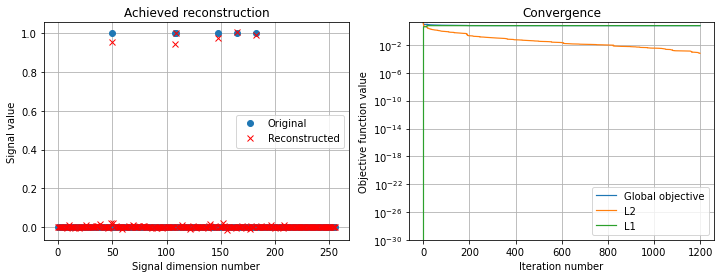

SNR: 27.97 dB


In [43]:
A_ROP = ROP_model(Om, a_ij, N)
A_ROP_r = Op2Real(A_ROP)
y_ROP_r = A_ROP_r@f
recovery = bpalg(A_ROP_r, y_ROP_r)
x_ROP = recovery[0]
xnorm1 = recovery[3]["xnorm1"]
rnorm2 = recovery[3]["rnorm2"]
show_rec1D(f, x_ROP, np.array([rnorm2, xnorm1]).T, labels=['L2', 'L1'], linewidth=1.2 )

With multiplicity correction

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01


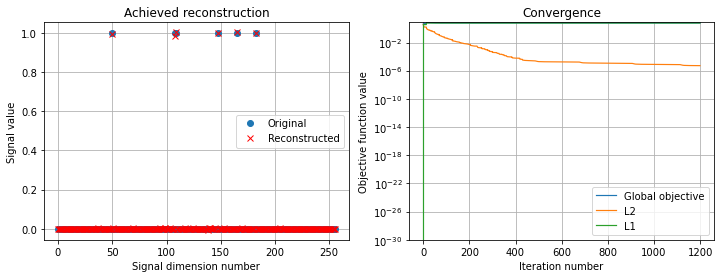

SNR: 40.64 dB


In [44]:
A_ROP = ROP_model(Om, a_ij, N, mult_mat=multiplicities)
A_ROP_r = Op2Real(A_ROP)
y_ROP_r = A_ROP_r@f
recovery = bpalg(A_ROP_r, y_ROP_r)
x_ROP = recovery[0]
xnorm1 = recovery[3]["xnorm1"]
rnorm2 = recovery[3]["rnorm2"]
show_rec1D(f, x_ROP, np.array([rnorm2, xnorm1]).T, labels=['L2', 'L1'], linewidth=1.2 )